In [15]:
import numpy as np
rng = np.random.default_rng(seed=11)

import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
import time

In this tutorial, we consider two 2D agents in a shared space. Each agent has a *preference* for where they want to be in the space, represented as a 2D probability density function (PDF). At the same time, they are minimizing a shared objective function, in this case a risk function that prevents them from being too close to each other. The BRNE finds the optimal *''agreement''* between the two agents based on the notion of Nash equilibrium (NE). It means that at convergence, each agent will compromise their preference in exchange for safety, and each agent is ''happy'' with each other's decision. 

In [16]:
# define the initial probability distributions (preferences) for both agents
mean1 = rng.uniform(low=0.4, high=0.6, size=(2,))
cov1 = np.array([[0.03, -0.01], [-0.01, 0.03]])
prob1 = mvn(mean=mean1, cov=cov1)

mean2 = rng.uniform(low=0.4, high=0.6, size=(2,))
cov2 = np.array([[0.04, 0.02], [0.02, 0.02]])
prob2 = mvn(mean=mean2, cov=cov2)

In [17]:
# we store the probabilty distributions in discrete form
# we will discretize a 1-by-1 space and evaluate the density function over it
grids_x, grids_y = np.meshgrid(
    np.linspace(0.0, 1.0, 100), np.linspace(0.0, 1.0, 100)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 0.01
dy = 0.01

prob1_grids = prob1.pdf(grids)
prob2_grids = prob2.pdf(grids)

Here is the math behind of the algorithm.

At the $k$-th interaction, we denote the current the probability distribution for the two agents as $p_1^{[k]}(x)$ and $p_2^{[k]}(x)$.

We want the agents to maintain a distance of $\beta$ meters. We can define an interaction function based on a quadratic function:

$$
r(x, x^\prime) = \alpha \cdot (\vert x-x^\prime \vert - \beta)^2
$$

where $\alpha$ is a parameter controls the magnitude of the function.

The overall goal for both agents to update their probability distributions to minimize this interaction functions:

$$
J(p_1(x), p_2(x)) = \mathbb{E}_{p_1,p_2}[r] = \int \int r(x, x^\prime) p_1(x) p_2(x^\prime) dx dx^\prime
$$

But minimizing this function alone is numerically ill-conditioned --- at the minimum the distribution $p_1$ and $p_2$ will converge to two distribution with extremely narrow peaks (Dirac delta functions) that are $d$ meters apart. Furthermore, optimizing both probability distributions simultaneously is also tricky.

The solution is to optimize each agent's probability distribution sequentially through the following formula:

$$
\begin{align}
p_1^{[k+1]}(x) & = {\arg\min}_{p_1} \text{ } J(p_1(x), p_2^{[k]}(x)) + D_{KL}(p_1(x) \Vert p_1^{[0]}(x)) \\
& = \frac{p_1^{[k]}(x) \cdot \int r(x,x^\prime) p_2^{[k]}(x^\prime) dx^\prime}{\int \left[ p_1^{[0]}(x) \cdot \int r(x,x^\prime) p_2^{[k]}(x^\prime) dx^\prime \right] dx} \\
& = \eta \cdot p_1^{[0]}(x) \cdot \int r(x,x^\prime) p_2^{[k]}(x^\prime) dx^\prime
\end{align}
$$

$$
\begin{align}
p_2^{[k+1]}(x) & = {\arg\min}_{p_2} \text{ } J(p_1^{[k+1]}(x), p_2(x)) + D_{KL}(p_2(x) \Vert p_2^{[0]}(x)) \\
& = \frac{p_2^{[k]}(x) \cdot \int r(x,x^\prime) p_1^{[k+1]}(x^\prime) dx^\prime}{\int \left[ p_2^{[0]}(x) \cdot \int r(x,x^\prime) p_1^{[k+1]}(x^\prime) dx^\prime \right] dx} \\
& = \eta \cdot p_2^{[0]}(x) \cdot \int r(x,x^\prime) p_1^{[k+1]}(x^\prime) dx^\prime
\end{align}
$$

Iteratively doing this will guarantee the reduction of the $J(p_1(x), p_2(x))$. At the same time, the KL-divergence term regulates each agent's new probability distribution with the previous distribution, providing the necessary numerical stability.

Another nice thing of the algorithm is that, it works with any kind of interaction function $r(x, x^\prime)$. The function can even be non-smooth and non-differentiable.

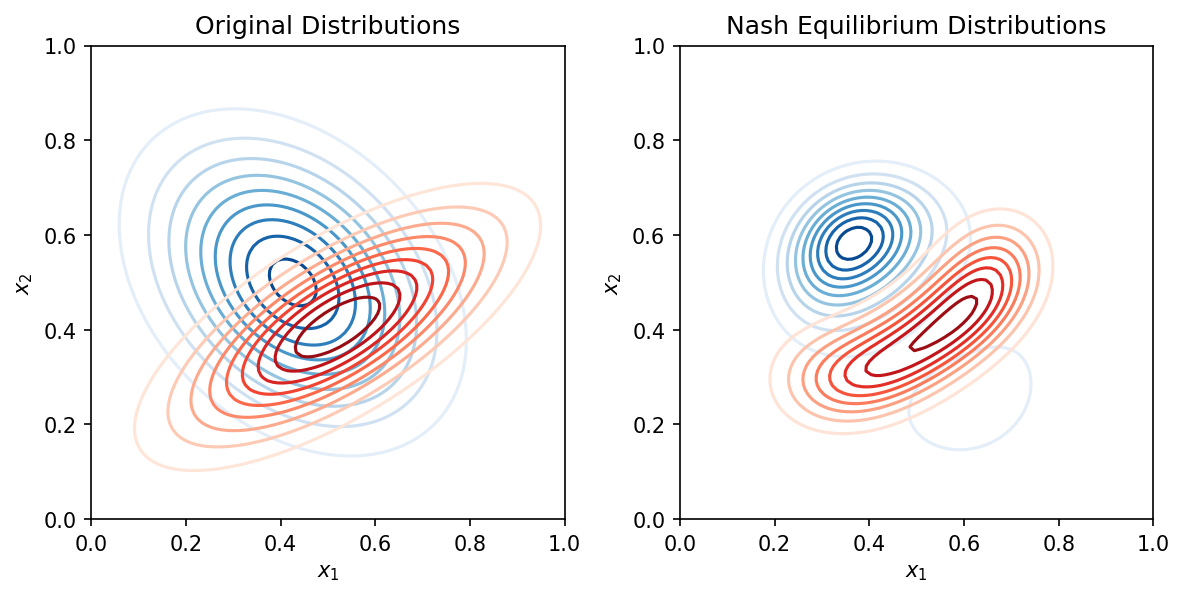

In [21]:
# we start modeling the social interaction here

# parameters
beta = 0.3  # desired distance
alpha = 100.0

# iterated agent probability distributions
prob1_k = prob1_grids.copy()
prob1_0 = prob1_k.copy()
prob2_k = prob2_grids.copy()
prob2_0 = prob2_k.copy()

# we pre-calculate the risk function across all possible grid cells
# to save time during the iteration
# here I use NumPy's broadcasting feature to simplify computation (avoiding explicit for loops)
dx_array = np.linalg.norm(grids - grids[:,np.newaxis], axis=2)
interact_array = alpha * np.square(dx_array - beta)

# prepare visualization
from IPython import display
fig, axes = plt.subplots(1, 2, figsize=(8,4), dpi=150, tight_layout=True)
ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.contour(grids_x, grids_y, prob1_grids.reshape(grids_x.shape), levels=10, cmap='Blues')
ax.contour(grids_x, grids_y, prob2_grids.reshape(grids_x.shape), levels=10, cmap='Reds')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('Original Distributions')

num_iters = 10
for iter in range(num_iters):
    prob1_new = prob1_0 * np.exp(-np.sum(interact_array * prob2_k, axis=1) * dx * dy)
    prob1_new /= np.sum(prob1_new) * dx * dy  # normalization
    prob1_k = prob1_new.copy()

    prob2_new = prob2_0 * np.exp(-np.sum(interact_array * prob1_k, axis=1) * dx * dy)
    prob2_new /= np.sum(prob2_new) * dx * dy  # normalization
    prob2_k = prob2_new.copy()

# visualization
ax = axes[1]
ax.cla()
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.contour(grids_x, grids_y, prob1_k.reshape(grids_x.shape), levels=10, cmap='Blues')
ax.contour(grids_x, grids_y, prob2_k.reshape(grids_x.shape), levels=10, cmap='Reds')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('Nash Equilibrium Distributions'.format(iter))
plt.show()
plt.close()
